In [1]:
# Includes
import matplotlib.pyplot as plt
import numpy as np
from scipy.fftpack import fft2, ifft2, fftshift
from scipy.signal import fftconvolve
from scipy.signal import argrelextrema

%matplotlib inline

## Parameters
# Image specs
nxy = 512
center = int(nxy/2)

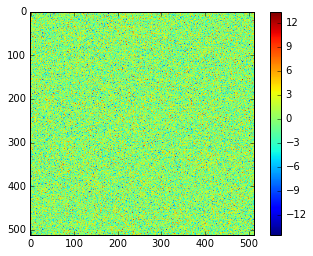

In [2]:
# Generate random image
# To be used in creating random atmospheric element
phase_phase = np.multiply(np.pi,np.random.normal(loc=0,scale=1,size=(nxy,nxy)))
plt.figure()
plt.imshow(phase_phase)
plt.colorbar()

/home/niels/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:75: RuntimeWarning: divide by zero encountered in power


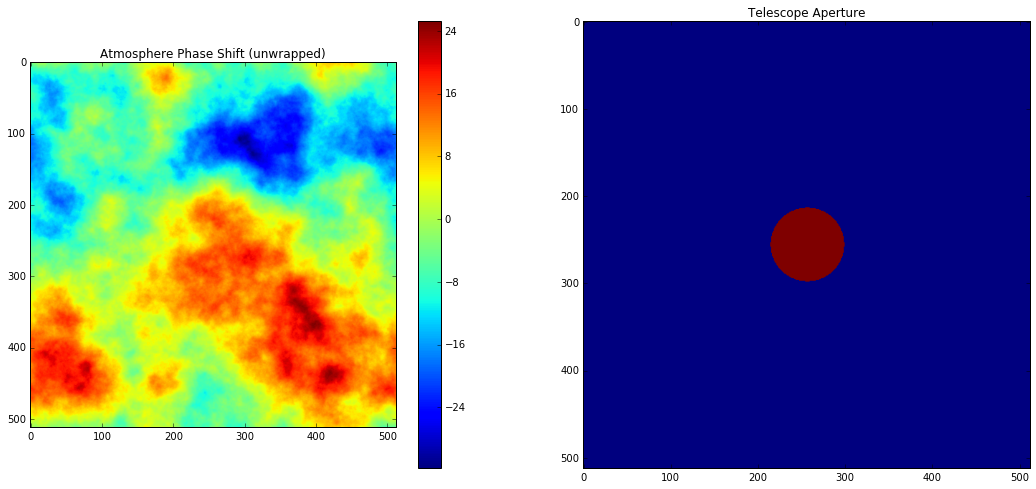

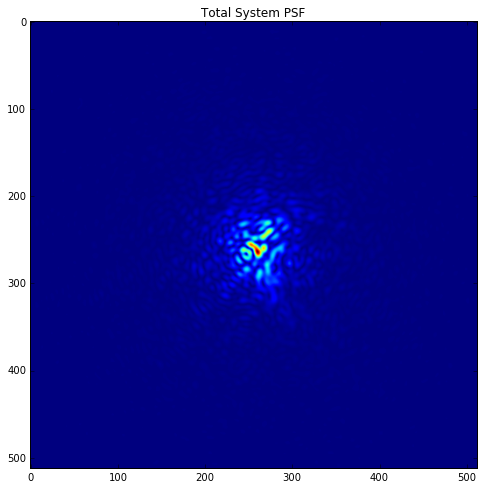

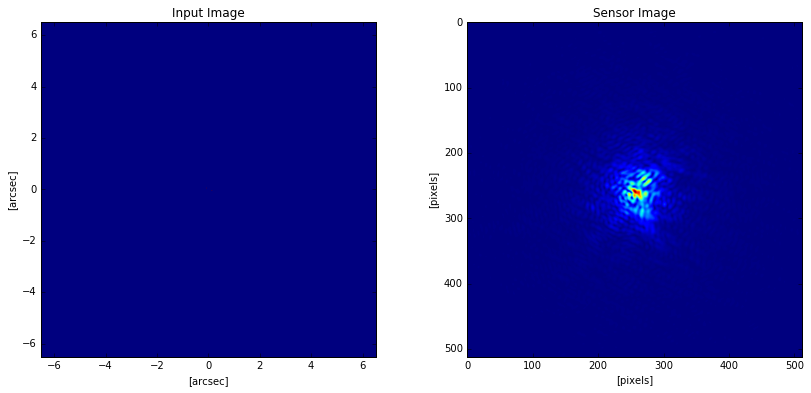

In [3]:
# Aperture/Telescope Specifications:
diameter_m = 2.133 # Mirror diameter in meters
focal_length = 129.69 # Effective focal length in meters
wavelength = 0.8E-6 # Wavelength of light
pixel = 8E-6 # Dimension of a pixel
diameter_m = 2.133 # Telescope diameter in m

## Creating Binary Star Input Image
# For KP 2.1m telescope, input image is in units of 25.44 milliarcseconds
platescale = 0.02544 # Plate scale in arcsec/pixel
rho = 0.25 # Set separation in arcseconds
phi = 30 # Set angle in degrees
# Calculate coordinates of stars
x = int( rho/(2*platescale) * np.cos(np.deg2rad(phi)) )
y = int( rho/(2*platescale) * np.sin(np.deg2rad(phi)) )
x1 = center + x
y1 = center + y
x2 = center - x
y2 = center - y    
# Empty input image
input_img = np.zeros((nxy,nxy)) 
# Place stars on image
input_img[y1,x1] = 1 
input_img[y2,x2] = 1
# Scale image power to 1
input_img_power = np.sum(np.power(input_img,2))
input_img = np.divide(input_img,np.sqrt(input_img_power))


## Telescope aperture creation:
# Total spatial sample range
X_aperture_s = 1/pixel 
# dx value for sampled aperture image
dx_aperture_s = X_aperture_s/nxy 
# Coordinates of sampled image
x_aperture_s = np.arange(0,X_aperture_s,dx_aperture_s) - X_aperture_s/2
# Meshgrid of sampled coordinates
xx_s,yy_s = np.meshgrid(x_aperture_s,x_aperture_s)
# Scaled aperture diameter to effectively resample aperture image
diameter_s = diameter_m/(focal_length*wavelength)
# Draw new circle at correct dimensions
# Calculate grid of distances from circle center
circle_s = (xx_s) ** 2 + (yy_s) ** 2 
# Draw boolean circle
circle_s = circle_s < (diameter_s/2)**2 
# Convert boolean circle to int
circle_s= circle_s.astype(np.int64)
# Save aperture image in units of meters
aperture_screen_s = circle_s
# Scale aperture image power to 1
aperture_screen_power = np.sum(np.power(aperture_screen_s,2))
aperture_screen_s = np.divide(aperture_screen_s,np.sqrt(aperture_screen_power))
# Calculate effective size of sampled aperture image in meters
X_aperture_s_meff = focal_length*wavelength/pixel

## Phase screen creation:
# Total array sample size
d_aperture = X_aperture_s_meff
# Fried parameter [m]
r0 = 0.2
# Spatial sample resolution
dxy = d_aperture/nxy
# Spatial frequency resolution
df = 1/(d_aperture) 
# Image sample indices array
x = np.multiply( np.subtract(np.arange(nxy),int(nxy/2)), dxy )
# Spatial Frequency indices array
xf = np.multiply( np.subtract(np.arange(nxy),int(nxy/2)), df )
# Meshgrid of spatial frequency domain
[xx,yy]=np.meshgrid(xf,xf)
# Radius from center meshgrid
rr = (np.sqrt(np.power(xx,2)+np.power(yy,2)))
# Calculate Kolmogorov spectral density
alpha = 1/100
phase_PSD = np.power(rr,-11/3)
phase_PSD = np.multiply(alpha*0.023/(r0**(5/3)),phase_PSD)
# Set DC component to 0 (previous calc attempts to set to 1/0)
phase_PSD[int(nxy/2),int(nxy/2)] = 0 
# Construct phase screen spectrum
phase_screen_f = np.multiply(np.sqrt(phase_PSD),np.exp(1j*phase_phase))
# Calculate phase screen
phase_screen = np.real(ifft2(fftshift(phase_screen_f)*nxy*nxy))
# Create complex atmospheric screen
atmosphere_screen = np.exp(np.multiply(1j,phase_screen))

# Generate total screen, combining atmosphere and aperture
pupil_screen = np.multiply(atmosphere_screen,aperture_screen_s)

## Calculate system's total response 
# Calculate total PSF of system
psf = fftshift(fft2(pupil_screen))
psf = np.power(np.abs(psf),2)
# Normalize PSF
psf_power = np.sum(np.power(psf,2))
psf = np.divide(psf,psf_power)
# Gamma correct PSF
gamma = 1.6
psf = np.power(psf,1/gamma)
# Convolve PSF with input image using FFT
sensor_img = fftconvolve(input_img,psf)
# Save the center 512x512 image
sensor_img = sensor_img[center:center+nxy,center:center+nxy] 

##Plots
colormap = "jet"

plt.figure(figsize = (18,8), dpi = 200)
plt.subplot(1,2,1)
plt.imshow(phase_screen, cmap=colormap)
plt.colorbar()
plt.title("Atmosphere Phase Shift (unwrapped)")
plt.subplot(1,2,2)
plt.imshow(aperture_screen_s, cmap=colormap)
plt.title("Telescope Aperture")

plt.figure(figsize = (8,8), dpi = 200)
plt.imshow(psf, cmap=colormap)
plt.title("Total System PSF")

plt.figure(figsize = (14,6), dpi = 200)
plt.subplot(1,2,1)
plt.imshow(input_img, cmap=colormap, extent = (-6.513,6.513,-6.513,6.513))
plt.xlabel("[arcsec]")
plt.ylabel("[arcsec]")
plt.title("Input Image")
plt.subplot(1,2,2)
plt.imshow(sensor_img, cmap=colormap)
plt.xlabel("[pixels]")
plt.ylabel("[pixels]")
plt.title("Sensor Image")

-1.50348348138e-20
1000629


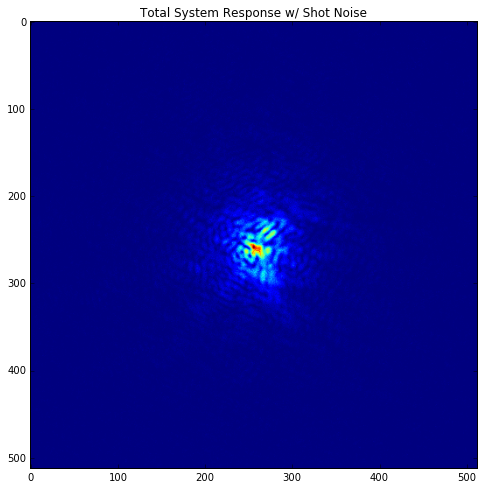

In [28]:
photons = 1000000

img_normalized = np.abs(sensor_img)/(np.sum(sensor_img))
print(sensor_img.min())
img_scaled = img_normalized*photons
img_shot_noise = np.random.poisson(lam=img_scaled, size=None)

plt.figure(figsize = (8,8), dpi = 200)
plt.imshow(img_shot_noise, cmap=colormap)
plt.title("Total System Response w/ Shot Noise")

print(np.sum(img_shot_noise))